### Setup

#### Imports

In [1]:
import json
import folium
import random
import requests
import kml2geojson
import numpy as np
import pandas as pd
import urllib.parse
import seaborn as sns
import networkx as nx
import link_identifier
import pymysql.cursors
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

from geopy import distance
from sklearn.neighbors import KernelDensity
from mpl_toolkits.basemap import Basemap as Basemap
from sklearn.datasets import fetch_species_distributions

# import constants
# from mpl_toolkits.basemap import Basemap
# also install `pip install basemap-data-hires`

#### Defines

In [2]:
# this information is prcured from Matt's processing
dataCenters =  {
                "CMEAurora" : {
                        "idx": 0,
                        "name":"CMEAurora", 
                        "lat": 41.7965685, 
                        "lon": -88.245206,
                        "searchRadius": 0.01}, 
                "ThreeFityCermakChicago" : {
                        "idx": 1,
                        "name":"ThreeFityCermakChicago", 
                        "lat": 41.8533031, 
                        "lon": -87.6318695,
                        "searchRadius": 0.01},
                "ThreeFityCermakNJ" : {
                        "idx": 2,
                        "name":"ThreeFityCermakNJ", 
                        "lat": 40.5842564, 
                        "lon": -74.2443242,
                        "searchRadius": 0.01},
                "NY5Secaucus" : {
                        "idx": 3,
                        "name":"NY5Secaucus", 
                        "lat": 40.7785384, 
                        "lon": -74.0744313,
                        "searchRadius": 0.01},
                "NY2Secaucus" : {
                        "idx": 4,
                        "name":"NY2Secaucus", 
                        "lat": 40.7772145, 
                        "lon": -74.0781314,
                        "searchRadius": 0.01}, 
                # "NY4Secaucus" : {"name":"NY4Secaucus", "lat": 40.7772145, "lon": -74.0781314}, 
                "NJ2Weehawken" : {
                        "idx": 5,
                        "name":"NJ2Weehawken", 
                        "lat": 40.7618291, 
                        "lon": -74.0272254,
                        "searchRadius": 0.01},
                "NYSEMahwah" : {
                        "idx": 6,
                        "name":"NYSEMahwah", 
                        "lat": 41.0783617, 
                        "lon": -74.1551081,
                        "searchRadius": 0.01}, 
                "FedWashingtonDC" : {
                        "idx": 7,
                        "name":"FedWashingtonDC", 
                        "lat": 38.9028647, 
                        "lon": -77.0313835,
                        "searchRadius": 0.01}, 
                "TmxToronto" : {
                        "idx": 8,
                        "name":"TmxToronto", 
                        "lat": 43.6486441, 
                        "lon": -79.3840116,
                        "searchRadius": 0.1}
                }
                
dataCenterNames = dataCenters.keys()
numberOfDataCenters = len(dataCenterNames)

print("Number Of Data Centers: ", numberOfDataCenters)

# defining a general basemap for plotting graphs overlay and colormap for path depiction
m = Basemap(
        projection='merc',
        epsg='4269',
        llcrnrlon=-90,llcrnrlat=38,urcrnrlon=-70,urcrnrlat=45,
        # lat_1=32,lat_2=45,lon_0=-95,
        resolution="h",
        suppress_ticks=True)
cmap = ['r', 'b', "yellow", 'm', "orange", "purple", "pink", "brown", "gold", "violet", "limegreen", "darkorange", "grey"]

Number Of Data Centers:  9


#### SQL connection setup

In [3]:
# Establish Connection to SQL Server
connection = pymysql.connect(host='127.0.0.1',  # type: ignore
						port=3306,
						user='root',
						password='vagrant',
						db='python_fcc_db_test',
						charset='utf8mb4',
						cursorclass=pymysql.cursors.DictCursor,
						autocommit=True)

cursor = connection.cursor()

#### Helper Functions

In [4]:
# defining the node Object
class Node():
    def __init__(self, lat, lon, email, callsign, r):
        if email==None:
            self.id = str(round(lat, 6)) + str(round(lon, 6))
        else:
            self.id = str(round(lat, 6)) + str(round(lon, 6)) + "-" + email
        # self.id = callsign + "-" + str(r)
        self.lat = round(lat, 6)
        self.lon = round(lon, 6)
        self.email = email
        self.callSign = callsign

In [5]:
class nxHelper:
    def __init__(self):
        print("iniitiated..")

    # find points that are in radius of the center by distance
    def findPointsClosestTo(self, centerLat, centerLon, radius, G):
        diff = radius #difference in latitide/longitude allowed to deviate from the center point
        nodesNear10kmOfCenter = filter(lambda n: ((abs(G.nodes[n]['data'].lat - centerLat) <= diff) and (abs(G.nodes[n]['data'].lon - centerLon) <= diff)), list(G.nodes()))
        return list(nodesNear10kmOfCenter)

    # find nodes that have the highest degree - limit number of nodes returned by the second argument
    def findNodesWithHighestDegree(self, G, numberOfTopNodes):
        degreeList = sorted(G.degree, key=lambda x: x[1], reverse=True)
        return degreeList[0:numberOfTopNodes]

### Data

#### Reading Input Data

In [6]:
# Read data from DB using SQL query and filtered links sent by Matt
fd = open('sql_query_for_ipynb.sql', 'r')
sql = fd.read()        
cursor.execute(sql)
results = cursor.fetchall()

# Read callsigns to filter from Matt's Data
filter_df = pd.read_csv(r'/vagrant/google_maps_SEC/data/Input/finalstep5.csv')

#### Processing Data

In [7]:
# Load the call signs in a set for filtering
callsign_set = set()
for i in range(len(filter_df['callsign'])):
    callsign_set.add(filter_df['callsign'][i])

# senderPoints = list of sender node objects, receiverPoints = list of receiver node objects
senderPoints = []
receiverPoints = []

senderPoints_set = set()
receiverPoints_set = set()

# append filtered data to list of objects
for result in results:
    if(result['call_sign'] in callsign_set):

        myNode = Node(result['lat_decimal'], result['lon_decimal'], result['email'], result['call_sign'], 1)
        senderPoints.append(myNode)
        senderPoints_set.add(myNode)

        myNode_r = Node(result['r_lat_decimal'], result['r_lon_decimal'], result['email'], result['call_sign'], 2)
        receiverPoints.append(myNode_r)
        receiverPoints_set.add(myNode_r)

print("Number of nodes in data:", len(senderPoints))
print("Number of nodes in set (unique):", len(senderPoints_set))

Number of nodes in data: 40475
Number of nodes in set (unique): 40475


#### Graph Initialization

In [8]:
G = nx.Graph()

n = min(len(senderPoints), len(receiverPoints))
pos={}

# adding nodes to graph and setting their aboslute position using coordinates in map
for node in senderPoints_set:
    node1 = node.id
    mx1, my1 = m(node.lon, node.lat)
    pos[node1] = (mx1, my1)
    G.add_node(node1, pos=(node.lat, node.lon), data=node)

for node in receiverPoints_set:
    node2 = node.id
    mx2, my2 = m(node.lon, node.lat)
    pos[node2] = (mx2, my2)
    G.add_node(node2, pos=(node.lat, node.lon), data=node)

# add edges
for i in range(n):
    node1 = senderPoints[i].id
    node2 = receiverPoints[i].id

    # no self loops
    if(node1==node2 or (node1 not in G) or (node2 not in G)):
        continue

    # compute length or distance between sender and receiver node
    dist = distance.distance((senderPoints[i].lat, senderPoints[i].lon), (receiverPoints[i].lat, receiverPoints[i].lon)).miles
    G.add_edge(node1, node2, weight=dist)


print("Number of nodes in the Graph:", G.number_of_nodes())
print("Number of edges in the Graph:", G.number_of_edges())


Number of nodes in the Graph: 24804
Number of edges in the Graph: 20624


### Plot paths

#### Whole graph using filtered data

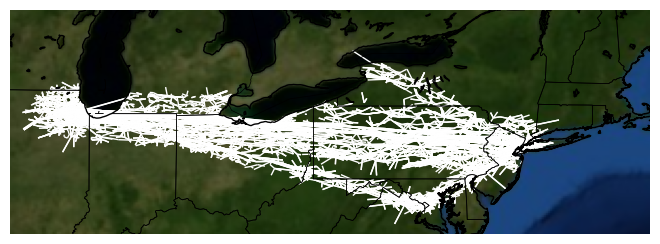

In [9]:
# source: https://stackoverflow.com/questions/19915266/drawing-a-graph-with-networkx-on-a-basemap
nx.draw(G, pos, with_labels=False, node_size=0, node_color='blue', edge_color='white')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.show()

#### Points closest to exchanges

In [10]:
# 2D matrix to store minimum number of links between any 2 data centers
minNumberOfLinksBetweenDataCenters = [[10000]*numberOfDataCenters]*numberOfDataCenters

# 2D matrix to store shortest path length between any 2 data centers
shortestPathLengthBetweenDataCenters = [[10000]*numberOfDataCenters]*numberOfDataCenters

# list of lists to store closest nodes (in randomized order) to each data center (order same as dict)
h = nxHelper()
nodesClosestToDataCenters = []
for A in dataCenters:
    closestPoints = h.findPointsClosestTo(dataCenters[A]["lat"], dataCenters[A]["lon"], dataCenters[A]["searchRadius"], G)
    random.shuffle(closestPoints)
    nodesClosestToDataCenters.append(closestPoints)

# 2D matrix to store geographic distance between any 2 data centers
geographicDistanceBetweenDataCenters = []
for A in dataCenters:
    dist = []
    for B in dataCenters:
        dist.append(distance.distance((dataCenters[A]["lat"], dataCenters[A]["lon"]), (dataCenters[B]["lat"], dataCenters[B]["lon"])).miles)
    geographicDistanceBetweenDataCenters.append(dist)

# logs
for A in dataCenters:
    for B in dataCenters:
        print("Distance between", A, "and", B, ": ", geographicDistanceBetweenDataCenters[dataCenters[A]["idx"]][dataCenters[B]["idx"]], "mi")

# logs
for A in dataCenters:
    print("Number of points near", A, ": ", len(nodesClosestToDataCenters[dataCenters[A]["idx"]]))

iniitiated..
Distance between CMEAurora and CMEAurora :  0.0 mi
Distance between CMEAurora and ThreeFityCermakChicago :  31.90274914950961 mi
Distance between CMEAurora and ThreeFityCermakNJ :  733.7936636126317 mi
Distance between CMEAurora and NY5Secaucus :  740.0960198173697 mi
Distance between CMEAurora and NY2Secaucus :  739.9209735224322 mi
Distance between CMEAurora and NJ2Weehawken :  742.7368149493317 mi
Distance between CMEAurora and NYSEMahwah :  732.5793782071515 mi
Distance between CMEAurora and FedWashingtonDC :  624.171755426047 mi
Distance between CMEAurora and TmxToronto :  468.4895506446468 mi
Distance between ThreeFityCermakChicago and CMEAurora :  31.90274914950961 mi
Distance between ThreeFityCermakChicago and ThreeFityCermakChicago :  0.0 mi
Distance between ThreeFityCermakChicago and ThreeFityCermakNJ :  702.3138122847232 mi
Distance between ThreeFityCermakChicago and NY5Secaucus :  708.5157542298558 mi
Distance between ThreeFityCermakChicago and NY2Secaucus :  7

In [11]:
for A in dataCenters:
    nx.draw_networkx_nodes(G, pos, nodelist=nodesClosestToDataCenters[dataCenters[A]["idx"]], node_size=1, node_color='white')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.show()

### Actual Code

#### shortest paths from point in 10km radius of CME to 10km of NASDAQ

In [12]:
# print("Found Path #", end='')

pathsEdgeList = [] # edges in the path
pathsNodeList = [] # nodes in the path
pathsEdges_set = set()
pathsNumberOfLinks = [] # number of links in each path
pathsLength = [] # length of each path in miles

flag = False
numberOfPaths = 0 # keep count of total number of paths found
numberOfPathsLimit = 10000000

# iterate over all sets of points near data centers
for A, idxA in zip(dataCenters, range(numberOfDataCenters)):
        for B, idxB in zip(dataCenters, range(numberOfDataCenters)):

                if A==B:
                        continue

                print("Searching paths between", A, " and", B)

                # check for all paths from nodes in set A to nodes in set B 
                for nA in nodesClosestToDataCenters[idxA]:
                        for nB in nodesClosestToDataCenters[idxB]:

                                # id of node is stored in 0th index of the list element's tuple
                                nodeA = nA
                                nodeB = nB
                                numberOfPaths = 0

                                if( nx.has_path(G, nodeA, nodeB) ):

                                        shortestPath = nx.shortest_path(G, source = nodeA, target = nodeB, weight='weight')
                                        shortestPathWeight = nx.path_weight(G, shortestPath, weight="weight")
                                        # shortestPathWeight = nx.shortest_path_length(G, source = node_c.id, target = node_n.id, weight='weight')
                                        shortestPathLength = len(shortestPath)
                                        
                                        minNumberOfLinksBetweenDataCenters[idxA][idxB] = min(minNumberOfLinksBetweenDataCenters[idxA][idxB], shortestPathLength)
                                        shortestPathLengthBetweenDataCenters[idxA][idxB] = min(shortestPathLengthBetweenDataCenters[idxA][idxB], shortestPathWeight)

                                        print("Shortest Path Weight: ", shortestPathWeight)
                                        print("Number of links in the shortest path: ", shortestPathLength)

                                        for path in nx.all_simple_paths(G, source = nodeA, target = nodeB, cutoff=(minNumberOfLinksBetweenDataCenters[idxA][idxB]+3)):

                                                # print("Trying to find simple paths...")

                                                pathWeight = nx.path_weight(G, path, weight='weight')

                                                # if path length is not within 50 miles of the distance between datacenter A and B
                                                if abs(pathWeight - shortestPathLengthBetweenDataCenters[idxA][idxB]) > 20:
                                                        continue
                                                
                                                pathEdges = list(zip(path,path[1:]))
                                                pathsEdgeList.append(pathEdges)
                                                pathsNodeList.append(path)
                                                pathsLength.append(pathWeight)
                                                for i in pathEdges:
                                                        pathsEdges_set.add(i)

                                                numberOfPaths = numberOfPaths + 1
                                                if(numberOfPaths>100):
                                                        numberOfPaths = 0
                                                        break
                                                b = "Found Path #" + str(numberOfPaths)
                                                # print (b, end="\r")
                                                print(b)

Searching paths between CMEAurora  and ThreeFityCermakChicago
Shortest Path Weight:  129.9507988572997
Number of links in the shortest path:  6
Found Path #1
Shortest Path Weight:  99.97748786419285
Number of links in the shortest path:  4
Found Path #1
Shortest Path Weight:  99.98864943245971
Number of links in the shortest path:  4
Found Path #1
Shortest Path Weight:  32.20459365913583
Number of links in the shortest path:  2
Found Path #1
Shortest Path Weight:  32.2157552274027
Number of links in the shortest path:  2
Found Path #1
Shortest Path Weight:  100.29229870831406
Number of links in the shortest path:  5
Shortest Path Weight:  100.30346027658095
Number of links in the shortest path:  5
Shortest Path Weight:  130.219028959636
Number of links in the shortest path:  6
Shortest Path Weight:  100.6503608708818
Number of links in the shortest path:  6
Shortest Path Weight:  100.66152243914865
Number of links in the shortest path:  6
Searching paths between CMEAurora  and ThreeFit

In [21]:
for i in range(10):
    print(pathsNodeList[i])

['41.800556-88.236111-sbc.noc@highland-systems.com', '41.772778-87.997222-sbc.noc@highland-systems.com', '41.761833-87.556472-sbc.noc@highland-systems.com', '41.657556-86.717806-sbc.noc@highland-systems.com', '41.634917-87.049806-sbc.noc@highland-systems.com', '41.858611-87.624111-sbc.noc@highland-systems.com']
['41.79925-88.236444-legal@wcwtech.com', '41.793611-87.583194-legal@wcwtech.com', '41.796222-88.242167-legal@wcwtech.com', '41.855028-87.623278-legal@wcwtech.com']
['41.79925-88.236444-legal@wcwtech.com', '41.793611-87.583194-legal@wcwtech.com', '41.796222-88.242167-legal@wcwtech.com', '41.855167-87.623083-legal@wcwtech.com']
['41.796222-88.242167-legal@wcwtech.com', '41.855028-87.623278-legal@wcwtech.com']
['41.796222-88.242167-legal@wcwtech.com', '41.855167-87.623083-legal@wcwtech.com']
['41.80025-88.239583-Rob.Russin@cfnservices.com', '41.610139-88.009167-Rob.Russin@cfnservices.com', '41.554139-87.373639-Rob.Russin@cfnservices.com', '41.61875-86.816472-Rob.Russin@cfnservices.

In [17]:
k = 0
print(len(pathsNodeList))
for p in pathsNodeList:
    email_set = set()
    print(set)
    
    for node in p:

        email_set.add(G.nodes[node]['data'].email)
    print(email_set)
    if(len(email_set)==1):
        k = k+1

print(k)


20306
{'sbc.noc@highland-systems.com'}
{'legal@wcwtech.com'}
{'legal@wcwtech.com'}
{'legal@wcwtech.com'}
{'legal@wcwtech.com'}
{'Rob.Russin@cfnservices.com'}
{'Rob.Russin@cfnservices.com'}
{'Rob.Russin@cfnservices.com'}
{'sbc.noc@highland-systems.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblineholdings.com'}
{'fcc-info@weblinehol

In [13]:
# Summary
print("Number of Paths Found: ", len(pathsLength))
# iterate over all sets of points near data centers
for A, idxA in zip(dataCenters, range(numberOfDataCenters)):
        for B, idxB in zip(dataCenters, range(numberOfDataCenters)):
                print("Shortest Path Length between", A, "and", B, ": ", shortestPathLengthBetweenDataCenters[idxA][idxB], "mi")
                print("Min number of Links between", A, "and", B, ": ", minNumberOfLinksBetweenDataCenters[idxA][idxB])

Number of Paths Found:  20306
Shortest Path Length between CMEAurora and CMEAurora :  32.20459365913583 mi
Min number of Links between CMEAurora and CMEAurora :  2
Shortest Path Length between CMEAurora and ThreeFityCermakChicago :  32.20459365913583 mi
Min number of Links between CMEAurora and ThreeFityCermakChicago :  2
Shortest Path Length between CMEAurora and ThreeFityCermakNJ :  16.872093492308007 mi
Min number of Links between CMEAurora and ThreeFityCermakNJ :  3
Shortest Path Length between CMEAurora and NY5Secaucus :  0 mi
Min number of Links between CMEAurora and NY5Secaucus :  1
Shortest Path Length between CMEAurora and NY2Secaucus :  0 mi
Min number of Links between CMEAurora and NY2Secaucus :  1
Shortest Path Length between CMEAurora and NJ2Weehawken :  2.405569921651509 mi
Min number of Links between CMEAurora and NJ2Weehawken :  2
Shortest Path Length between CMEAurora and NYSEMahwah :  23.741445797389996 mi
Min number of Links between CMEAurora and NYSEMahwah :  4
Shor

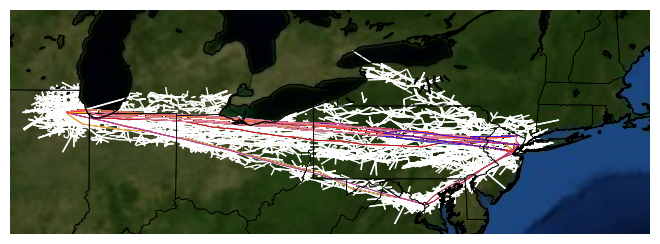

In [16]:

# draw graph showing all paths
nx.draw(G, pos, with_labels=False, node_size=0, node_color='blue', edge_color='white')
for i in range(len(pathsLength)):
    nx.draw_networkx_edges(G, pos, edgelist=pathsEdgeList[i],edge_color=cmap[i%10], width=0.5, connectionstyle='arc3, rad = 0.3')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.savefig('fooAll.pdf')
plt.show()


In [ ]:

# draw graph showing all paths
nx.draw(G, pos, with_labels=False, node_size=0, node_color='blue', edge_color='white')
random.shuffle(pathsEdgeList)
for i in range(1000):
    nx.draw_networkx_edges(G, pos, edgelist=pathsEdgeList[i],edge_color=cmap[i%10], width=0.5, connectionstyle='arc3, rad = 0.3')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.savefig('fooAll.pdf')
plt.show()


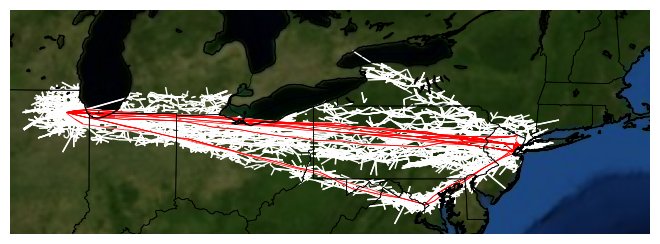

In [18]:
nx.draw(G, pos, with_labels=False, node_size=0, node_color='blue', edge_color='white')
for j in pathsEdges_set:
        nx.draw_networkx_edges(G, pos, edgelist=[j] ,edge_color='r', width=0.5, connectionstyle='arc3, rad = 0.3')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.savefig('fooAll1.pdf')
plt.show()

### Output emails and nodes

In [22]:
# list all associated email in the path nodes
# find minimum distance node to CME and NASDAQ for each apth

emailSet = set()
callsignSet = set()

# minDistToCME = []
# minDistToNASDAQ = []

# minDistNodeToCME = []
# minDistNodeToNASDAQ = []

for path in pathsNodeList:

    # pathMinDistToCME = 10000.0
    # pathMinDistToNASDAQ = 10000.0

    # pathMinDistNodeToCME = ""
    # pathMinDistNodeToNASDAQ = ""

    for node in path:

        n = G.nodes[node]['data']

        emailSet.add(n.email)
        callsignSet.add(n.callSign)

    #     distToCME = distance.distance((n.lat, n.lon), (CME_datacenter_lat, CME_datacenter_long)).miles
    #     distToNASDAQ = distance.distance((n.lat, n.lon), (NASDAQ_datacenter_lat, NASDAQ_datacenter_long)).miles

    #     pathMinDistToCME = min(pathMinDistToCME, distToCME)
    #     pathMinDistToNASDAQ = min(pathMinDistToNASDAQ, distToNASDAQ)

    #     if(pathMinDistToCME==distToCME):
    #         pathMinDistNodeToCME = n.id
    #     if(pathMinDistToNASDAQ==distToNASDAQ):
    #         pathMinDistNodeToNASDAQ = n.id
    
    # minDistToCME.append(pathMinDistToCME)
    # minDistToNASDAQ.append(pathMinDistToNASDAQ)
    # minDistNodeToCME.append(pathMinDistNodeToCME)
    # minDistNodeToNASDAQ.append(pathMinDistNodeToNASDAQ)

# print(minDistToCME)
# print(minDistNodeToCME)
# for i in minDistNodeToCME:
#     print(G.nodes[i]['data'].id)



### Exports

#### Email and Callsigns

In [25]:
emailFile = open("../data/networkX_Results/emailFile.txt", "w")
callsignFile = open("../data/networkX_Results/callsignFile.txt", "w")
for email in emailSet:
    emailFile.write(str(email))
    emailFile.write("\n")
for callsign in callsignSet:
    callsignFile.write(callsign)
    callsignFile.write("\n")

### Extra Snippets

In [ ]:
CME_datacenter_lat = 41.7993472
CME_datacenter_long = -88.2417858

NASDAQ_datacenter_lat = 40.585606187252445
NASDAQ_datacenter_long = -74.24154709139276

FedReserve_hq_lat = 38.893279884940014
FedReserve_hq_long = -77.04555349377686

#  sort nodes by their degree
a = sorted(G.degree, key=lambda x: x[1], reverse=True)
a[0:10]

DFS Tree of a sample node

In [ ]:
# Find the node object of this coordinate
sourceNode = "41.822944-88.331139-reg"
path = nx.dfs_tree(G, source=sourceNode, depth_limit=300)

nx.draw(G, pos, with_labels=False, node_size=0, node_color='blue', edge_color='white')
nx.draw_networkx_edges(G, pos, edgelist=path.edges(),edge_color='r', connectionstyle='arc3, rad = 0.3')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.show()

Shortest path from a node near Chicago to New York

In [ ]:
# highlighting the shortest path from a node to destination
flag = False
node1 = ""
node2 = ""
pathsEdgeList = [] # edges in the path
pathsNodeList = [] # nodes in the path
numberOfPaths = 0
numberOfPathsLimit = 30

# get list of nodes and shuffle them
nodeList = list(G.nodes(data=True))
random.shuffle(nodeList)
numberOfNodes = len(nodeList)

for i in range(numberOfNodes):
        
        for j in range(numberOfNodes):

                if(j==i):
                        continue

                # id of node is stored in 0th index of the list element's tuple
                node1 = nodeList[i][1]['data']
                node2 = nodeList[j][1]['data']

                nodeList[0][1]['data'].email

                if( (node1.lon<-85 and node1.lat>41) and (node2.lon>-75) and  (nx.has_path(G, node1.id, node2.id)) ):

                        path = nx.shortest_path(G, source = node1.id, target = node2.id)
                        
                        pathEdges = list(zip(path,path[1:]))
                        pathsEdgeList.append(pathEdges)
                        pathsNodeList.append(path)
                        
                        numberOfPaths = numberOfPaths + 1
                        print("Found Path #", numberOfPaths)
                        if numberOfPaths >= numberOfPathsLimit:
                                flag = True
                                break

                        # go to a different root node if a path is found
                        break

        if flag==True:
                break

In [ ]:
# list all associated email in the path nodes
# find minimum distance node to CME and NASDAQ for each apth

emailSet2 = set()

minDistToCME2 = []
minDistToNASDAQ2 = []

minDistNodeToCME2 = []
minDistNodeToNASDAQ2 = []

for path in pathsNodeList:

    pathMinDistToCME2 = 10000.0
    pathMinDistToNASDAQ2 = 10000.0

    pathMinDistNodeToCME2 = ""
    pathMinDistNodeToNASDAQ2 = ""

    for node in path:

        n = G.nodes[node]['data']

        emailSet2.add(n.email)

        distToCME2 = distance.distance((n.lat, n.lon), (CME_datacenter_lat, CME_datacenter_long)).miles
        distToNASDAQ2 = distance.distance((n.lat, n.lon), (NASDAQ_datacenter_lat, NASDAQ_datacenter_long)).miles

        pathMinDistToCME2 = min(pathMinDistToCME2, distToCME2)
        pathMinDistToNASDAQ2 = min(pathMinDistToNASDAQ2, distToNASDAQ2)

        if(pathMinDistToCME2==distToCME2):
            pathMinDistNodeToCME2 = n.id
        if(pathMinDistToNASDAQ2==distToNASDAQ2):
            pathMinDistNodeToNASDAQ = n.id
    
    minDistToCME2.append(pathMinDistToCME2)
    minDistToNASDAQ2.append(pathMinDistToNASDAQ2)
    minDistNodeToCME2.append(pathMinDistNodeToCME2)
    minDistNodeToNASDAQ2.append(pathMinDistNodeToNASDAQ2)

print(minDistToCME2)
print(minDistNodeToCME2)
for i in minDistNodeToCME2:
    print(G.nodes[i]['data'].id)
for email in emailSet2:
    print(email)